In [3]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../../")
import collections
import re
import numpy as np
import pandas as pd
#from utils.readvcf_snp import ReadVCF
#from utils import fst as Fst_calc

#pheno_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/gtex_v8_basic_phenotypes.txt"
#admix_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex-admixed0.9.txt"
eur_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
afr_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_afr.sample"
oth_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_oth.sample"
all_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"

def centerscale_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

def read_samples(samplefile):
    if os.path.exists(samplefile):
        with open(samplefile, 'r') as samfile:
            sample = 0
            samplenames = list()
            next(samfile)
            next(samfile)
            for line in samfile:
                if re.search('^#', line):
                    continue
                sample += 1
                samplenames.append(line.strip().split()[0])
        nsample = sample
        samplenames = samplenames
        return samplenames, nsample
    
all_samples, nall = read_samples(all_file)
eur_samples, neur = read_samples(eur_file)
afr_samples, nafr = read_samples(afr_file)
oth_samples, noth = read_samples(oth_file)

In [4]:
print(nall, neur, nafr, noth)

838 715 103 20


In [5]:
# read the samples for each tissue
tissue="as"
expr_dir = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms"
expr_file = os.path.join(expr_dir, "{:s}_tpms_qcfilter.txt".format(tissue))

df_expr = pd.read_csv(expr_file, header=0, sep="\t", index_col=0)

In [18]:
import random

def subtract_pop_means(df_expr, samples=[[], []]):
    expr_samples = df_expr.columns
    df_expr_sub = df_expr.copy()
    in_expr_sum = 0
    to_rmv = list()
    for sample_set in samples:
        if len(sample_set) == 0:
            print("sample set is empty")
            raise
        in_expr = [x for x in sample_set if x in expr_samples]
        if len(in_expr) == 0:
            continue
        in_expr_sum += len(in_expr)
        pop_mean = df_expr[in_expr].mean(axis=1)
        # print(pop_mean.iloc[:10])
        df_expr_sub[in_expr] = df_expr[in_expr].sub(pop_mean, axis=0)
        
        # randomly select one sample from this pop
        to_rmv.append(random.sample(in_expr, 2)[0])
    if in_expr_sum != df_expr_sub.shape[1]:
        print("Some samples were not found!")
        print(in_expr_sum, df_expr_sub.shape)
        raise
    return df_expr_sub.drop(to_rmv, axis=1)

In [19]:
df_expr_corr = subtract_pop_means(df_expr, samples=[eur_samples, afr_samples, oth_samples])
df_expr_corr = centerscale_expr(df_expr_corr)
print(df_expr_corr.shape, df_expr.shape)

(16353, 578) (16353, 581)


In [20]:
U, S, Vt     = np.linalg.svd(df_expr.values, full_matrices=False)
U, Scorr, Vt = np.linalg.svd(df_expr_corr.values, full_matrices=False)
print(S[-10:])
print(Scorr[-10:])

[8.60174202e+01 8.57479376e+01 8.50897805e+01 8.49288818e+01
 8.45775736e+01 8.42969420e+01 8.37196974e+01 8.31646654e+01
 8.23313475e+01 1.74811020e-12]
[8.64354314e+01 8.61025060e+01 8.57723083e+01 8.53023973e+01
 8.48589069e+01 8.43034680e+01 8.31684337e+01 3.42557189e+01
 1.13967667e+01 1.81204098e-13]


In [21]:
print(U.shape, Scorr.shape, Vt.shape)

(16353, 578) (578,) (578, 578)


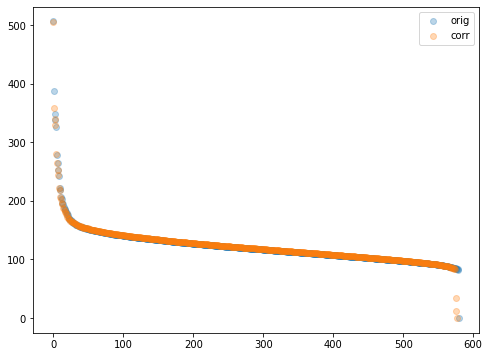

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax  = fig.add_subplot(111)
ax.scatter(np.arange(len(S)), S, label="orig", alpha=0.3)
ax.scatter(np.arange(len(Scorr)), Scorr, label="corr", alpha=0.3)
ax.legend()
plt.show()

## Process all tissues

In [65]:
from utils import utils

tissue_file = "../../plots/tissue_table.txt"
json_file   = "../../gtex_v8_metadata.json"
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)

In [72]:
expr_dir     = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms"
expr_outdir  = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/popcorr"

if not os.path.exists(expr_outdir):
    os.makedirs(expr_outdir)

for tissue in tshorts:
    print(f"processing {tissue}")
    expr_file    = os.path.join(expr_dir, "{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue))
    expr_outfile = os.path.join(expr_outdir, "{:s}_tpms_qcfilter_popcorr.txt.protein_coding_lncRNA_filtered".format(tissue))

    df_expr = pd.read_csv(expr_file, header=0, sep="\t", index_col=0)
    df_expr_corr = subtract_pop_means(df_expr, samples=[eur_samples, afr_samples, oth_samples])
    df_expr_corr = centerscale_expr(df_expr_corr)
    df_expr_corr.to_csv(expr_outfile, header=True, index=True, sep="\t")

processing as
processing av
processing ag
processing aa
processing ac
processing at
processing bam
processing ban
processing bca
processing bceh
processing bce
processing bco
processing bfr
processing bhi
processing bhy
processing bnu
processing bpu
processing bsp
processing bsu
processing br
processing ebv
processing fib
processing cols
processing colt
processing esog
processing esom
processing esomu
processing haa
processing hlv
processing kc
processing liv
processing lu
processing msg
processing ms
processing nt
processing ov
processing pan
processing pit
processing pro
processing snse
processing sse
processing si
processing spl
processing sto
processing tes
processing thy
processing ut
processing va
processing wb
